In [1]:
import pandas as pd
import itertools

## Google news

In [2]:
from GoogleNews import GoogleNews
googlenews = GoogleNews(start='01/01/2020',end='01/31/2020')
googlenews.get_news('Boeing Corporation')

In [3]:
import pandas as pd
a = pd.DataFrame(googlenews.results())
a['datetime']=pd.to_datetime(a['datetime'],errors='coerce')
a.title

0     How the McDonnell Douglas-Boeing merger led to...
1                   Airbus topples Boeing from top spot
2     How Much Of Boeing’s Revenues Comes From The U...
3     It's time to end corporate welfare. Boeing is ...
4     China's bid to challenge Boeing and Airbus fal...
                            ...                        
93    A dead NASA space telescope and an old Air For...
94           The Travel Corporation's John Veitch exits
95    Iran to send flight recorders from downed jet ...
96    Malaysia Airlines Passengers Get Mad After Two...
97    Russia’s Northern Fleet to Get New Anti-Submar...
Name: title, Length: 98, dtype: object

In [86]:
ticker_list = ['jpm','mcd','wmt','pg','unh','aapl','nke','vz','dis','jnj']
keywords = ["\"JP Morgan\"","\"McDonalds\"","\"Walmart\"","\"Proctor & Gamble\"","\"UnitedHealth Group\"","\"Apple\"","\"NIKE\"","\"Verizon Communications\"","\"Walt Disney\"","\"Johnson & Johnson\""]
keywords = ["JP Morgan","McDonald's","Walmart","Proctor & Gamble","UnitedHealth Group","Apple","NIKE","Verizon Communications","Walt Disney","Johnson & Johnson"]

In [106]:
from GoogleNews import GoogleNews
from datetime import datetime
import random

import time
res = pd.DataFrame()
for tic,keyword in enumerate(keywords):
    for year in range(2020,2023):
        for i in range(1,13):
            try:
                start_date = datetime(year, i, 1)
                if i in [1,3,5,7,8,10,12]:

                    end_date = datetime(year, i, 31)
                elif i==2:
                    end_date = datetime(year, i, 28)
                else:
                    end_date = datetime(year, i, 30)
                end_date = end_date.strftime("%m/%d/%Y")
                start_date = start_date.strftime("%m/%d/%Y")
                googlenews = GoogleNews(start = start_date,end=end_date)
                googlenews.get_news(keyword)  
                df = pd.DataFrame(googlenews.results())[['datetime','title']]
                if keyword=="Proctor & Gamble":
                    df['title'] = df['title'].apply(lambda x: x if (keyword in x) or ("P&G" in x) or ("P&G's" in x) else None)
                elif keyword=="NIKE":
                    df['title'] = df['title'].apply(lambda x: x if (keyword in x) or ("Nike" in x) else None)
                elif keyword=="Verizon Communications":
                    df['title'] = df['title'].apply(lambda x: x if (keyword in x) or ("Verizon" in x) else None)
                elif keyword=="JP Morgan":
                    df['title'] = df['title'].apply(lambda x: x if (keyword in x) or ("JPMorgan" in x) or ("J.P.Morgan" in x) else None)
                elif keyword=="Johnson & Johnson":
                    df['title'] = df['title'].apply(lambda x: x if (keyword in x) or ("J&J" in x) else None)
                else:
                    df['title'] = df['title'].apply(lambda x: x if keyword in x else None)
                # print(df['title'])
                df_filtered2 = df[~df['title'].isna()].reset_index(drop=True)
                # print(len(df_filtered2))
                # print(df_filtered2)
                # print("-"*100)
                # df = pd.DataFrame(googlenews.page_at(2))[['datetime','title']]
                df_filtered2['datetime']=pd.to_datetime(df_filtered2['datetime'],errors='coerce').dt.strftime('%Y-%m-%d')
                df_filtered2 = pd.concat([df_filtered2,pd.DataFrame({"tic":[ticker_list[tic]]*len(df_filtered2)})],axis=1)
                res = pd.concat([res,df_filtered2]).reset_index(drop=True)
        
                n = random.randint(1,3)
                time.sleep(n)
            except Exception as e:
                print(f"{keyword}_{year}_{i}month")
                print(e)
# res = res.reset_index(drop=True)
# res.to_csv("gnews_from2020to2022.csv",index = False)

In [143]:
res.groupby("tic").count()

,datetime,title
tic,,
aapl,3261,3261
dis,1381,1381
jnj,1628,1628
jpm,1726,1726
mcd,217,217
nke,3395,3395
pg,126,126
unh,144,144
vz,1319,1319


In [111]:
res.to_csv("gnews_from2020to2022_new.csv",index = False)

# Sentiment analysis

In [114]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import numpy as np
import pandas as pd
model = BertForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

sent = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

/home/samuel/.conda/envs/finrl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [115]:
df = pd.read_csv("./gnews_from2020to2022_new.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16435 entries, 0 to 16434
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  16435 non-null  object
 1   title     16435 non-null  object
 2   tic       16435 non-null  object
dtypes: object(3)
memory usage: 385.3+ KB


In [117]:
df = df[~df['title'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16435 entries, 0 to 16434
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  16435 non-null  object
 1   title     16435 non-null  object
 2   tic       16435 non-null  object
dtypes: object(3)
memory usage: 385.3+ KB


In [118]:
from tqdm import tqdm
tqdm.pandas()
df['score'] = df.progress_apply(lambda x :sent(x['title'])[0]['label'], axis=1)
df['score'] = df['score'].replace({"positive":1,"negative":-1,"neutral":0})

100%|████████████████████████████████████████████████████| 16435/16435 [04:58<00:00, 55.05it/s]


In [119]:
df = df[df['datetime']<"2023"]

In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16424 entries, 0 to 16434
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  16424 non-null  object
 1   title     16424 non-null  object
 2   tic       16424 non-null  object
 3   score     16424 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 641.6+ KB


In [132]:
df[['title','score']].iloc[20]['title'],df[['title','score']].iloc[20]['score']

('What’s up with WhatsApp? JP Morgan trader suspended over messages', 0)

In [133]:
score_df = df.sort_values(by="datetime").groupby(["tic","datetime"])['score'].mean()

In [134]:
score_df_transpose = score_df.unstack().transpose().fillna(0)

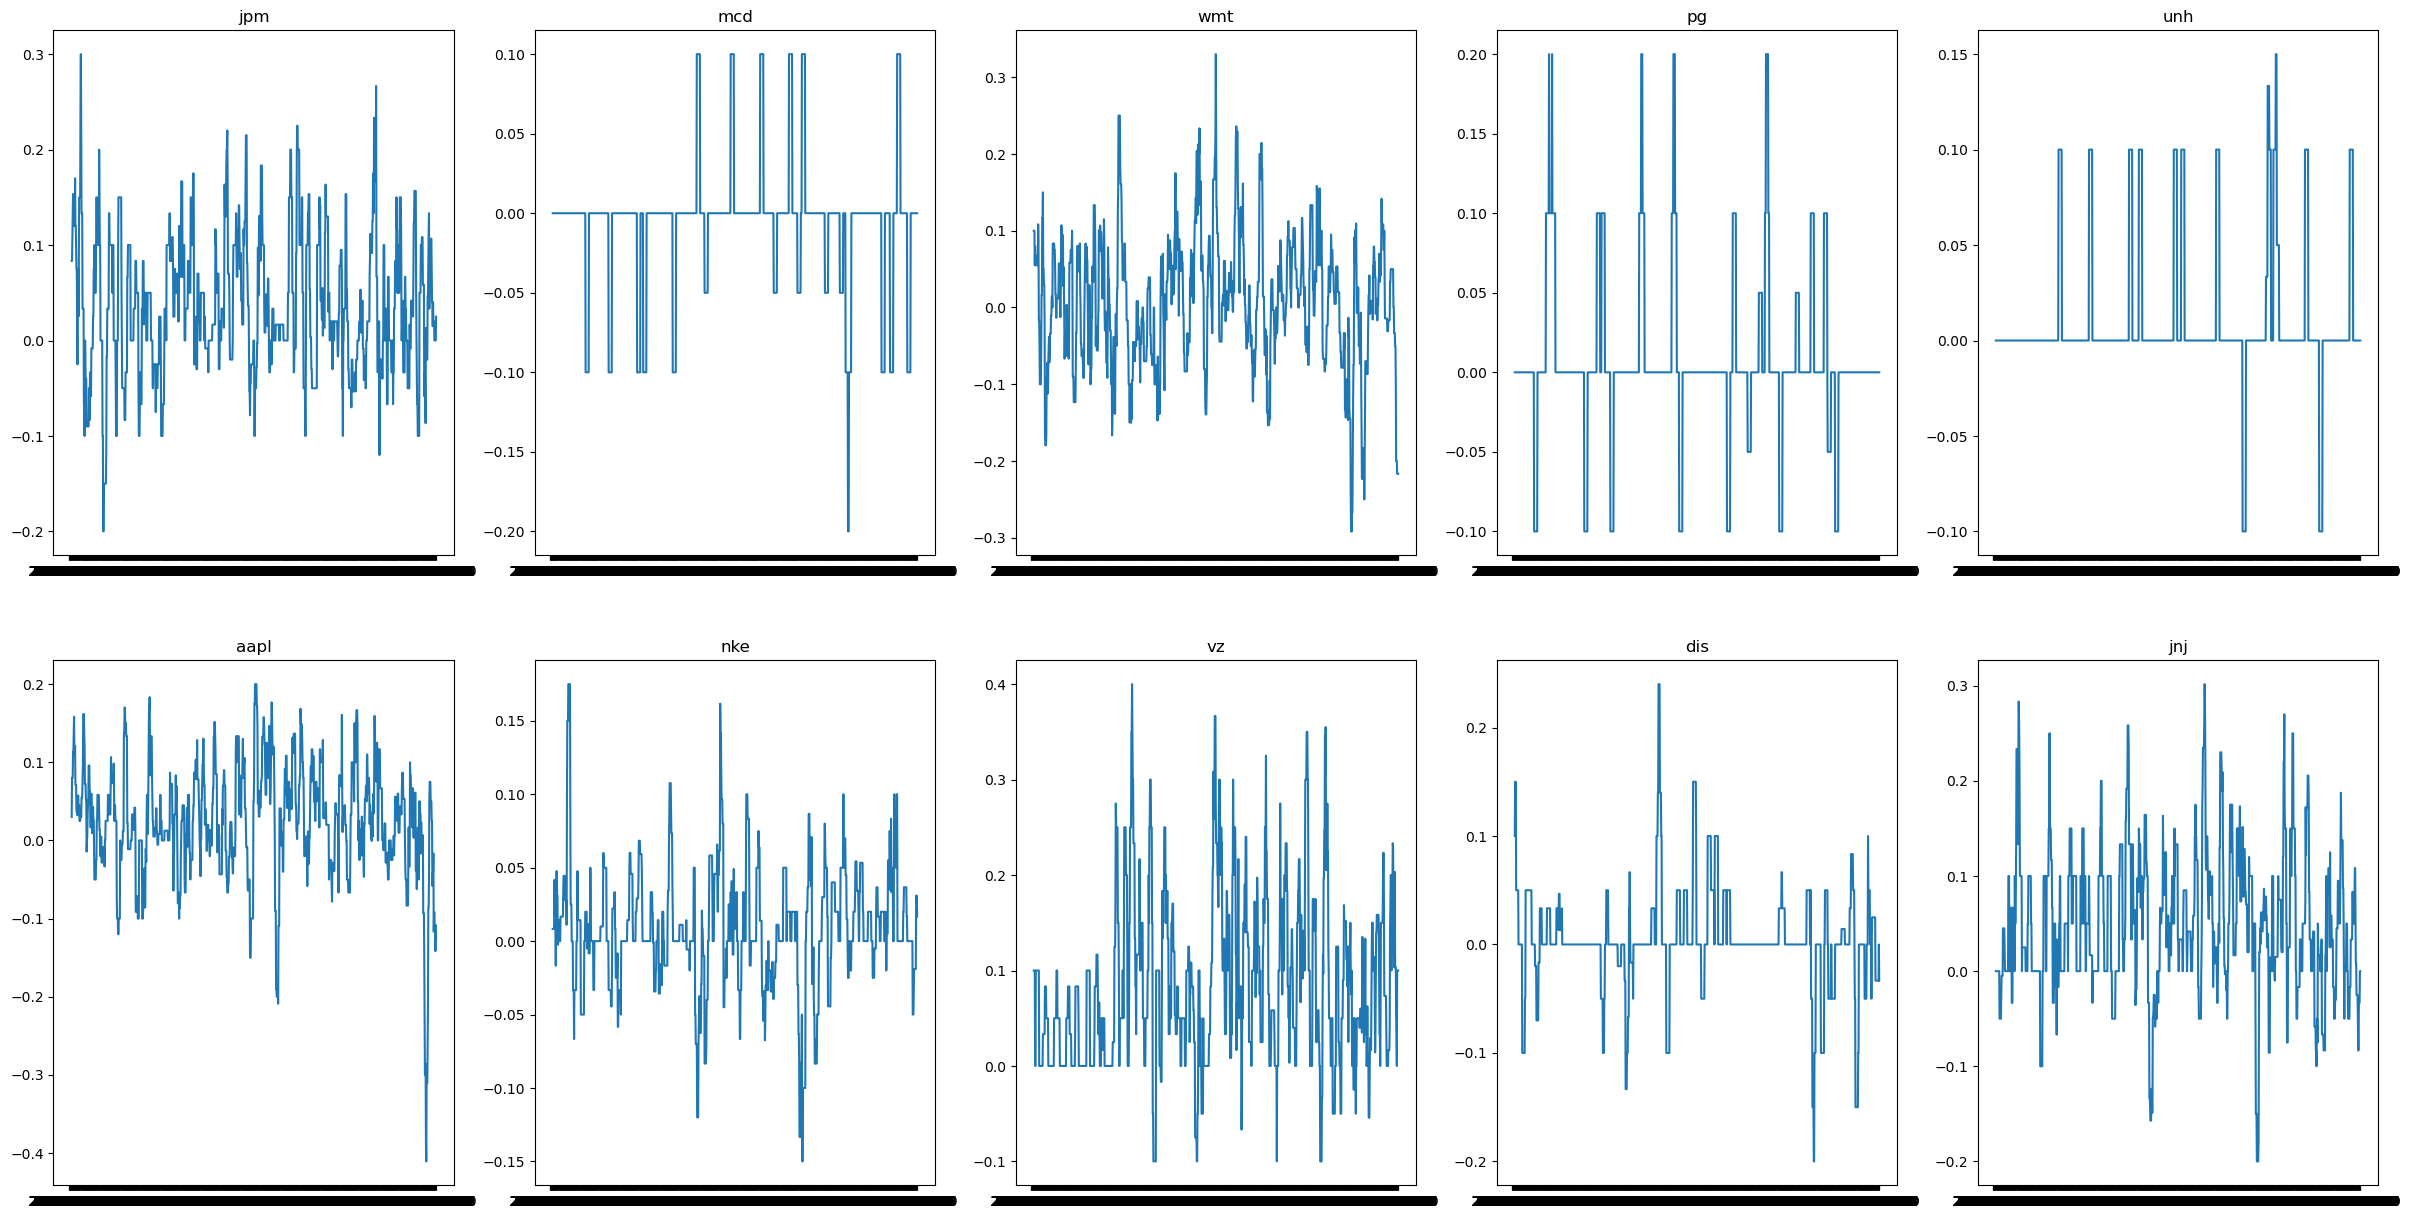

In [202]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,5,figsize=(30,15))
k=0
for i in range(2):
    for j in range(5):
        ax[i][j].plot(score_df_transpose[ticker_list[k]].rolling(10).mean())
        ax[i][j].set_title(f"{ticker_list[k]}")
        k+=1

In [157]:
test  = pd.melt(score_df_transpose.reset_index(), id_vars=['datetime'], var_name='tic', value_name='value')

In [163]:
test.to_csv("sentiment_score_new.csv",index=False)

# Google Trend

In [164]:
from pytrends.request import TrendReq
pytrend = TrendReq(hl='en-US', tz=360)

In [165]:
from datetime import datetime
end_date = datetime(2022, 1, 31)
datetime.strftime(end_date,"%Y-%m-%d")

'2022-01-31'

In [225]:
pytrend = TrendReq(hl='en-US', tz=360)
# keywords1 = ["Apple stock","NIKE stock","McDonalds stock","Walt Disney stock","Johnson & Johnson stock"]
# keywords2 = ["JP Morgan stock","Walmart stock","Proctor & Gamble stock","UnitedHealth Group stock","Verizon Communications stock"]
keywords1 = ["Apple","Nike","McDonald","Disney","Johnson & Johnson"]
keywords2 = ["JP Morgan","Walmart","P&G","UnitedHealth Group","Verizon"]
trend_day_df = pd.DataFrame()
for keyword in [keywords1,keywords2]:
    df = pd.DataFrame()
    for year in range(2020,2023):
        for i in range(1,13):
            start_date = datetime(year, i, 1)
            if i in [1,3,5,7,8,10,12]:
                end_date = datetime(year, i, 31)
            elif i==2:
                end_date = datetime(year, i, 28)
            else:
                end_date = datetime(year, i, 30)
            start_date = datetime.strftime(start_date,"%Y-%m-%d")
            end_date = datetime.strftime(end_date,"%Y-%m-%d")
            pytrend.build_payload(
             kw_list=keyword,
             timeframe=f'{start_date} {end_date}',
             geo='TW',
             gprop='')
            res = pytrend.interest_over_time()
            df = pd.concat([df,res])
    trend_day_df = pd.concat([trend_day_df,df],axis=1)

In [226]:
trend_day_df = trend_day_df.drop(["isPartial"],axis=1)
trend_day_df

,Apple,Nike,McDonald,Disney,Johnson & Johnson,JP Morgan,Walmart,P&G,UnitedHealth Group,Verizon
date,,,,,,,,,,
2020-01-01,87,48,1,12,0,0,29,35,0,50
2020-01-02,82,46,3,5,3,0,22,0,19,0
2020-01-03,84,52,1,8,0,0,0,0,59,90
2020-01-04,90,67,1,11,2,0,99,38,0,0
2020-01-05,94,75,1,11,0,0,0,0,0,24
...,...,...,...,...,...,...,...,...,...,...
2022-12-27,86,32,0,7,0,17,48,29,19,0
2022-12-28,81,37,1,6,0,0,23,26,0,0
2022-12-29,83,35,2,8,0,31,67,23,0,31


In [227]:
trend_day_df['time'] = trend_day_df.index.strftime('%Y-%m')

In [228]:
# keywords1 = ["Apple stock","Nike stock","McDonalds stock","Walt Disney stock","Johnson & Johnson stock"]
# keywords2 = ["JP Morgan stock","Walmart stock","Proctor & Gamble stock","UnitedHealth Group stock","Verizon Communications stock"]
keywords1 = ["Apple","Nike","McDonald","Disney","Johnson & Johnson"]
keywords2 = ["JP Morgan","Walmart","P&G","UnitedHealth Group","Verizon"]
trend_month_df = pd.DataFrame()
for keyword in [keywords1,keywords2]:
    pytrend.build_payload(
         kw_list=keyword,
         timeframe='all',
         geo='TW',
         gprop='')
    res = pytrend.interest_over_time()
    df = pd.DataFrame(res)[-41:]
    trend_month_df = pd.concat([trend_month_df,df],axis=1)

In [229]:
trend_month_df = trend_month_df.drop(["isPartial"],axis=1)

In [230]:
trend_month_df

,Apple,Nike,McDonald,Disney,Johnson & Johnson,JP Morgan,Walmart,P&G,UnitedHealth Group,Verizon
date,,,,,,,,,,
2020-01-01,46,31,1,4,0,4,38,10,1,9
2020-02-01,45,28,0,3,0,5,36,10,1,8
2020-03-01,45,27,0,3,0,5,32,12,0,13
2020-04-01,53,23,0,3,0,6,23,15,0,9
2020-05-01,49,28,0,3,0,4,21,12,1,7
2020-06-01,42,20,0,2,0,4,20,12,0,9
2020-07-01,45,22,0,2,0,5,14,9,1,9
2020-08-01,45,25,0,2,0,6,19,12,1,8
2020-09-01,71,22,0,2,0,6,17,11,1,9


In [231]:
trend_month_df =trend_month_df.iloc[:-5,:]
trend_month_df = trend_month_df/100

<Axes: xlabel='date'>

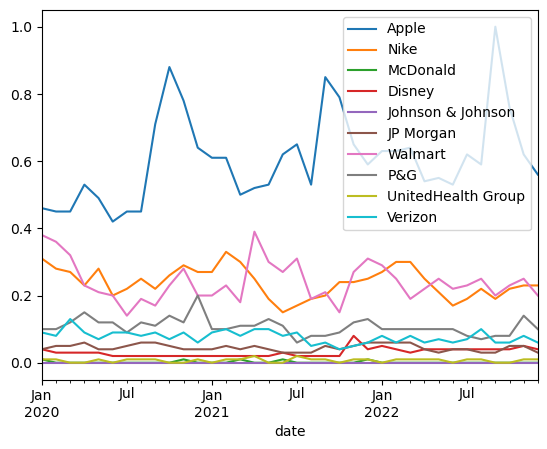

In [232]:
trend_month_df.iloc[:,:].plot()

In [233]:
trend_month_df['time'] = trend_month_df.index.strftime("%Y-%m")

In [234]:
trend_merge = trend_day_df.merge(trend_month_df,how="left",on="time")
trend_merge

,Apple_x,Nike_x,McDonald_x,Disney_x,Johnson & Johnson_x,JP Morgan_x,Walmart_x,P&G_x,UnitedHealth Group_x,Verizon_x,...,Apple_y,Nike_y,McDonald_y,Disney_y,Johnson & Johnson_y,JP Morgan_y,Walmart_y,P&G_y,UnitedHealth Group_y,Verizon_y
0,87,48,1,12,0,0,29,35,0,50,...,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
1,82,46,3,5,3,0,22,0,19,0,...,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
2,84,52,1,8,0,0,0,0,59,90,...,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
3,90,67,1,11,2,0,99,38,0,0,...,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
4,94,75,1,11,0,0,0,0,0,24,...,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,86,32,0,7,0,17,48,29,19,0,...,0.56,0.23,0.00,0.04,0.0,0.03,0.20,0.1,0.01,0.06
1091,81,37,1,6,0,0,23,26,0,0,...,0.56,0.23,0.00,0.04,0.0,0.03,0.20,0.1,0.01,0.06
1092,83,35,2,8,0,31,67,23,0,31,...,0.56,0.23,0.00,0.04,0.0,0.03,0.20,0.1,0.01,0.06
1093,91,31,0,8,0,0,23,38,68,0,...,0.56,0.23,0.00,0.04,0.0,0.03,0.20,0.1,0.01,0.06


In [235]:
trend_merge.index = trend_day_df.index
trend_merge = trend_merge.drop(['time'],axis=1)
trend_merge

,Apple_x,Nike_x,McDonald_x,Disney_x,Johnson & Johnson_x,JP Morgan_x,Walmart_x,P&G_x,UnitedHealth Group_x,Verizon_x,Apple_y,Nike_y,McDonald_y,Disney_y,Johnson & Johnson_y,JP Morgan_y,Walmart_y,P&G_y,UnitedHealth Group_y,Verizon_y
date,,,,,,,,,,,,,,,,,,,,
2020-01-01,87,48,1,12,0,0,29,35,0,50,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
2020-01-02,82,46,3,5,3,0,22,0,19,0,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
2020-01-03,84,52,1,8,0,0,0,0,59,90,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
2020-01-04,90,67,1,11,2,0,99,38,0,0,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
2020-01-05,94,75,1,11,0,0,0,0,0,24,0.46,0.31,0.01,0.04,0.0,0.04,0.38,0.1,0.01,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,86,32,0,7,0,17,48,29,19,0,0.56,0.23,0.00,0.04,0.0,0.03,0.20,0.1,0.01,0.06
2022-12-28,81,37,1,6,0,0,23,26,0,0,0.56,0.23,0.00,0.04,0.0,0.03,0.20,0.1,0.01,0.06
2022-12-29,83,35,2,8,0,31,67,23,0,31,0.56,0.23,0.00,0.04,0.0,0.03,0.20,0.1,0.01,0.06


In [238]:
trend_df = pd.DataFrame()
for i in range(int(len(trend_merge.columns)/2)):
    x ,y = trend_merge.iloc[:,i],trend_merge.iloc[:,i+10]
    trend_df = pd.concat([trend_df,pd.DataFrame(x*y,columns=[f'{trend_merge.columns[i]}'])],axis=1)

<Axes: xlabel='date'>

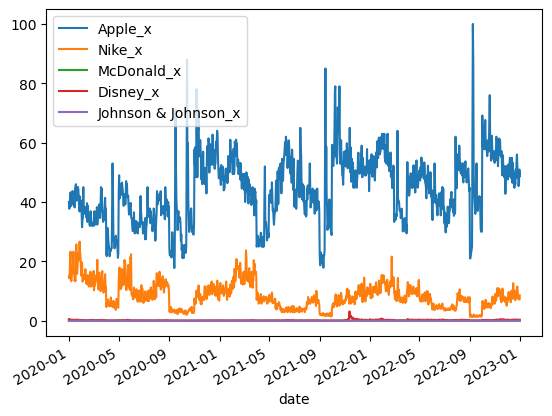

In [241]:
trend_df.iloc[:,:5].plot()

<Axes: xlabel='date'>

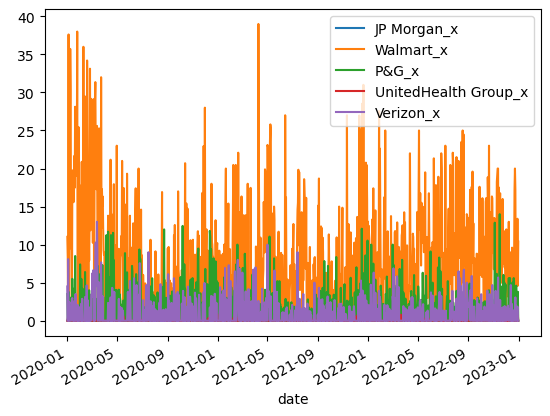

In [242]:
trend_df.iloc[:,5:].plot()